# Problema 2: Redes de Transporte



## 1. Conjuntos
$O$ : Conjunto de ciudades origen
$D$ : Conjunto de ciudades destino

## 2. Parámetros

- $Costo_{ij}$ : Costo de transporte por tonelada entre la ciudad de origen $i$ y la ciudad de destino $j$.
- $Demanda_j$ : Demanda en toneladas de la ciudad destino $j$.

- $S_i$ : Capacidad de oferta en cada ciudad de origen.
  - $S_{\text{Bogotá}} = 550$ toneladas
  - $S_{\text{Medellín}} = 700$ toneladas

## 3. Variables de decisión
 - $X_{ij}$ : Cantidad de toneladas transportadas desde la ciudad de origen $i$ a la ciudad de destino $j$

## 4. Función objetivo
 
La función objetivo busca minimizar el costo total de transporte. Se calcula como la suma de los costos de transporte por tonelada multiplicado por la cantidad de toneladas transportadas entre cada par de ciudades origen-destino:

 $min \sum_{i \in O} \sum_{j \in D} C_{ij}X_{ij}$

 Donde:
 - $C_{ij}$ es el costo de transporte por tonelada entre la ciudad origen $i$ y la ciudad destino $j$
 - $X_{ij}$ es la cantidad de toneladas transportadas desde la ciudad origen $i$ a la ciudad destino $j$

 ## 5. Restricciones
  
1 - La suma de los envíos a cada ciudad destino debe satisfacer exactamente su demanda
  
  - $\sum_{i \in O} X_{ij} = D_j \quad \forall j \in D$  

2 - Las ciudades que tienen conexión Origen - Destino con costo 0 no se tienen en cuenta como conexiones válidas para Bogotá
  - $X_{1,1} = 0$ (Bogotá-Cali)

3 - Las ciudades que tienen conexión Origen - Destino con costo 0 no se tienen en cuenta como conexiones válidas para Medellín
  - $X_{2,2} = 0$ (Medellín-Barranquilla)


4 - La suma de los envíos desde cada ciudad de origen debe ser menor o igual a su capacidad de oferta
  
  - $\sum_{j \in D} X_{ij} \leq S_i \quad \forall i \in O$


 ## 6. Tipo de problema
LP pues todas las variables de decisión son continuas (cantidades de toneladas a transportar), la función objetivo es lineal (suma de productos de costos por cantidades), y todas las restricciones son lineales.



### Implementación de esta formulación en pyomo:

In [2]:

from __future__ import division
from pyomo.environ import *

from pyomo.opt import SolverFactory

#modelo
Model_ = ConcreteModel()

# Data de entrada
ciudadesOrigen=2
ciudadesDestino=6

# Conjuntos
O=RangeSet(1, ciudadesOrigen)
D=RangeSet(1,ciudadesDestino)
 
# Parámetros
CostoDemanda = {
    1: {"Bogota": 0, "Medellin": 2.5, "Demanda": 125}, # 1 Cali
    2: {"Bogota": 2.5, "Medellin": 0, "Demanda": 175}, # 2 Barranquilla
    3: {"Bogota": 1.6, "Medellin": 2.0, "Demanda": 225}, # 3 Pasto
    4: {"Bogota": 1.4, "Medellin": 1.0, "Demanda": 250}, # 4 Tunja
    5: {"Bogota": 0.8, "Medellin": 0.8, "Demanda": 225}, # 5 Chía
    6: {"Bogota": 0.8, "Medellin": 0.8, "Demanda": 200}, # 6 Manizalez

}

# Oferta
Oferta = {
    1: 550,  # Bogota
    2: 700   # Medellin
}

# Variable de decisión
Model_.x = Var(O, D, domain=NonNegativeReals)

# Función objetivo
Model_.obj = Objective(expr = sum(Model_.x[i, j]* (CostoDemanda[j]["Bogota"] if i==1 else CostoDemanda[j]["Medellin"]) for i in O for j in D), sense=minimize)

# Restricciones
#1 - La suma de los envios de cada ciudad de origen a la destino debe ser igual a la capacidad de la ciudad destino 
Model_.rest1 = ConstraintList()
for j in D:
    Model_.rest1.add(expr = sum(Model_.x[i,j] for i in O) == CostoDemanda[j]["Demanda"])

#2 - Las ciudades que tienen conexion Origen - Destino == 0 no se tienen en cuenta como conexiones validas para Bogota
Model_.rest2 = ConstraintList()
for j in D:
    if CostoDemanda[j]["Bogota"] == 0:
        Model_.rest2.add(expr = Model_.x[1,j] == 0)

#3 - Las ciudades que tienen conexion Origen - Destino == 0 no se tienen en cuenta como conexiones validas para Medellin
Model_.rest3 = ConstraintList()
for j in D:
    if CostoDemanda[j]["Medellin"] == 0:
        Model_.rest3.add(expr = Model_.x[2,j] == 0)

#4 - Cada ciudad de origen no supera su limite de demanda
Model_.rest4 = ConstraintList()
for i in O:
    Model_.rest4.add(expr= sum(Model_.x[i,j] for j in D) <= Oferta[i])

# Especificación del solver
SolverFactory('glpk').solve(Model_)

Model_.display()



Model unknown

  Variables:
    x : Size=12, Index=[1:2]*[1:6]
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (1, 2) :     0 : 175.0 :  None : False : False : NonNegativeReals
        (1, 3) :     0 : 225.0 :  None : False : False : NonNegativeReals
        (1, 4) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (1, 5) :     0 : 100.0 :  None : False : False : NonNegativeReals
        (1, 6) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 1) :     0 : 125.0 :  None : False : False : NonNegativeReals
        (2, 2) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 4) :     0 : 250.0 :  None : False : False : NonNegativeReals
        (2, 5) :     0 : 125.0 :  None : False : False : NonNegativeReals
        (2, 6) :     0 : 200.0 :  None : False : False : No

### Implementación del nuevo cambio: mover 50 toneladas de oferta de Medellín a Bogotá

In [3]:

from __future__ import division
from pyomo.environ import *

from pyomo.opt import SolverFactory

#modelo
Model_nuevo = ConcreteModel()

# Datos de entrada
ciudadesOrigen=2
ciudadesDestino=6

# Conjuntos
O=RangeSet(1, ciudadesOrigen)
D=RangeSet(1,ciudadesDestino)
 
# Parámetros
CostoDemanda = {
    1: {"Bogota": 0, "Medellin": 2.5, "Demanda": 125}, # 1 Cali
    2: {"Bogota": 2.5, "Medellin": 0, "Demanda": 175}, # 2 Barranquilla
    3: {"Bogota": 1.6, "Medellin": 2.0, "Demanda": 225}, # 3 Pasto
    4: {"Bogota": 1.4, "Medellin": 1.0, "Demanda": 250}, # 4 Tunja
    5: {"Bogota": 0.8, "Medellin": 0.8, "Demanda": 225}, # 5 Chía
    6: {"Bogota": 0.8, "Medellin": 0.8, "Demanda": 200}, # 6 Manizalez

}

# Oferta
Oferta = {
    1: (550 + 50),  # Bogota, con 50 toneladas movidas de Medellin
    2: (700 - 50)   # Medellin
}

# Variable de decisión
Model_nuevo.x = Var(O, D, domain=NonNegativeReals)

# Función objetivo
Model_nuevo.obj = Objective(expr = sum(Model_nuevo.x[i, j]* (CostoDemanda[j]["Bogota"] if i==1 else CostoDemanda[j]["Medellin"]) for i in O for j in D), sense=minimize)

# Restricciones
#1 - La suma de los envios de cada ciudad de origen a la destino debe ser igual a la capacidad de la ciudad destino 
Model_nuevo.rest1 = ConstraintList()
for j in D:
    Model_nuevo.rest1.add(expr = sum(Model_nuevo.x[i,j] for i in O) == CostoDemanda[j]["Demanda"])

#2 - Las ciudades que tienen conexion Origen - Destino == 0 no se tienen en cuenta como conexiones validas para Bogota
Model_nuevo.rest2 = ConstraintList()
for j in D:
    if CostoDemanda[j]["Bogota"] == 0:
        Model_nuevo.rest2.add(expr = Model_nuevo.x[1,j] == 0)

#3 - Las ciudades que tienen conexion Origen - Destino == 0 no se tienen en cuenta como conexiones validas para Medellin
Model_nuevo.rest3 = ConstraintList()
for j in D:
    if CostoDemanda[j]["Medellin"] == 0:
        Model_nuevo.rest3.add(expr = Model_nuevo.x[2,j] == 0)

#4 - Cada ciudad de origen no supera su limite de demanda
Model_nuevo.rest4 = ConstraintList()
for i in O:
    Model_nuevo.rest4.add(expr= sum(Model_nuevo.x[i,j] for j in D) <= Oferta[i])

# Especificación del solver
SolverFactory('glpk').solve(Model_nuevo)

Model_nuevo.display()



Model unknown

  Variables:
    x : Size=12, Index=[1:2]*[1:6]
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (1, 2) :     0 : 175.0 :  None : False : False : NonNegativeReals
        (1, 3) :     0 : 225.0 :  None : False : False : NonNegativeReals
        (1, 4) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (1, 5) :     0 : 150.0 :  None : False : False : NonNegativeReals
        (1, 6) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 1) :     0 : 125.0 :  None : False : False : NonNegativeReals
        (2, 2) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 4) :     0 : 250.0 :  None : False : False : NonNegativeReals
        (2, 5) :     0 :  75.0 :  None : False : False : NonNegativeReals
        (2, 6) :     0 : 200.0 :  None : False : False : No

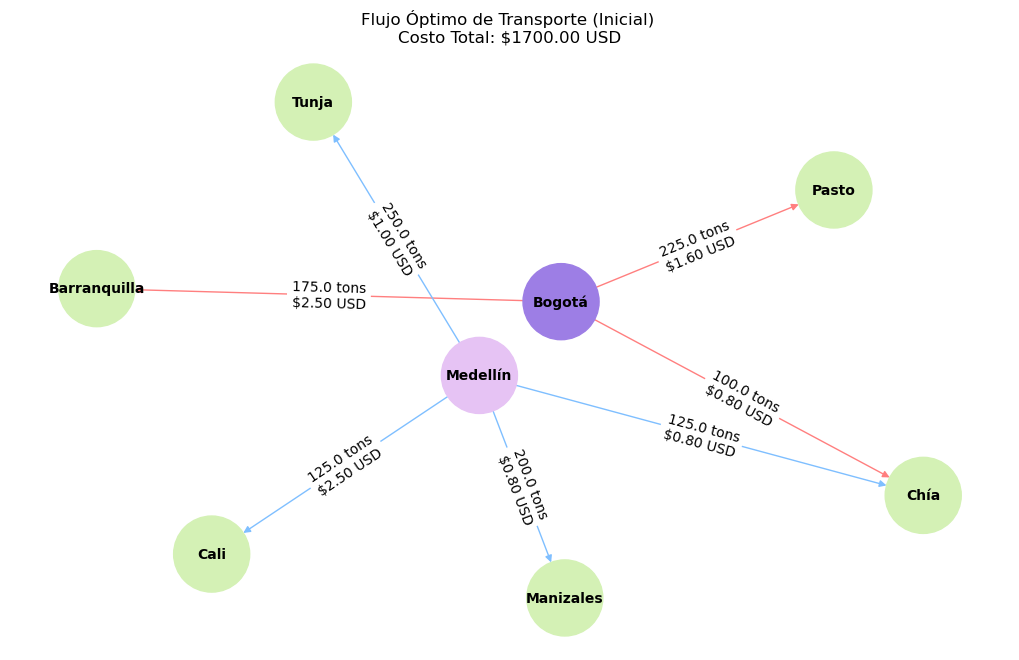

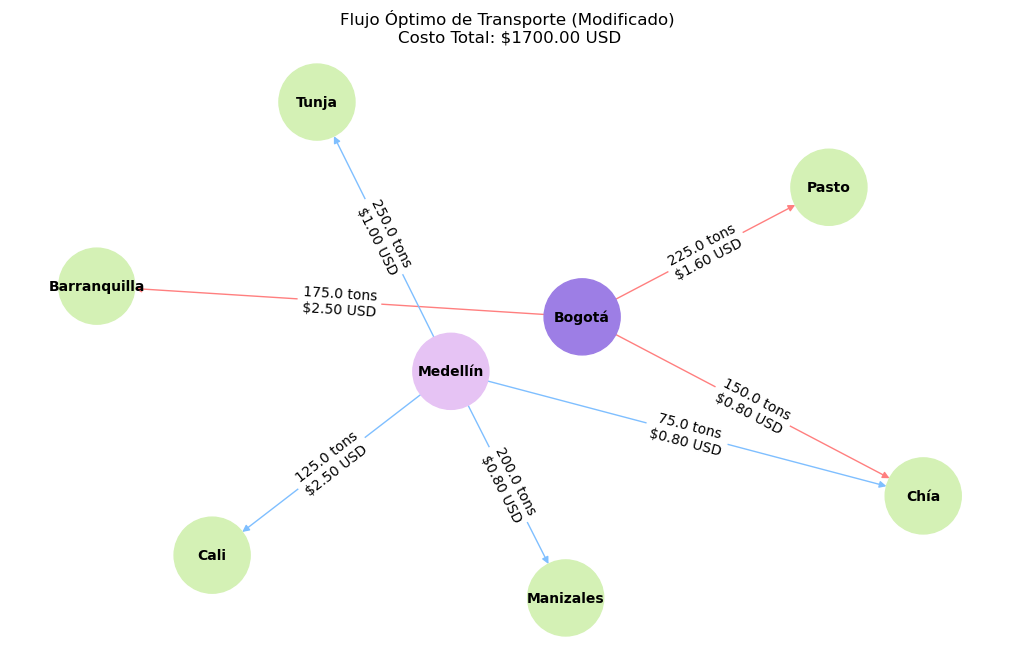

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def graficar_modelo_transporte(Model, titulo):
    G = nx.DiGraph()

    nombres_origen = {1: "Bogotá", 2: "Medellín"}
    nombres_destino = {
        1: "Cali",
        2: "Barranquilla",
        3: "Pasto",
        4: "Tunja",
        5: "Chía",
        6: "Manizales"
    }

    G.add_node(nombres_origen[1], color='#9d7ee5')
    G.add_node(nombres_origen[2], color='#e6c3f4')


    for j in D:
        G.add_node(nombres_destino[j], color='#d4f1b5')
    
    costo_total = 0
    for j in D:
        for i in O:
            if CostoDemanda[j]["Bogota"] if i==1 else CostoDemanda[j]["Medellin"] > 0:
                if Model.x[i, j].value != 0: 
                    flujo = Model.x[i, j].value  
                else:
                    flujo = 0
                    
                if flujo > 0:
                    costo = CostoDemanda[j]["Bogota"] if i==1 else CostoDemanda[j]["Medellin"]
                    costo_total += flujo * costo
                    G.add_edge(nombres_origen[i], nombres_destino[j], weight=flujo, label=f"{flujo:.1f} tons\n${costo:.2f} USD")

    pos = nx.spring_layout(G, seed=42)
    edges = G.edges(data=True)
    
    plt.figure(figsize=(10, 6))

    edge_colors = []
    for u, v, d in edges:
        if u == "Bogotá":  
            edge_colors.append('#ff7f7f')
        else:  
            edge_colors.append('#7fbfff')

    nx.draw(G, pos, with_labels=True, node_size=3000,
            node_color=[G.nodes[n]['color'] for n in G.nodes],
            edge_color=edge_colors, font_size=10, font_weight='bold')

    edge_labels = {(u, v): f"{d['label']}" for u, v, d in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title(f"{titulo} \nCosto Total: ${costo_total:.2f} USD")
    plt.show()

graficar_modelo_transporte(Model_, titulo="Flujo Óptimo de Transporte (Inicial)")
graficar_modelo_transporte(Model_nuevo, titulo="Flujo Óptimo de Transporte (Modificado)")
